In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams["font.size"] = 14

import utils
import importlib
importlib.reload(utils)

import os
import sys
import subprocess

In [2]:
train, test, info, index = utils.ReadData("debug3")

In [3]:
val = test.values
train_for_val = train.values

In [4]:
log_train_for_val = np.log1p(np.nan_to_num(train_for_val))

In [5]:
# restore indices of weekly seasonal, many zeros
weekly_indices = np.load("../data/google_wtts/weekly_index_for_score.npy")
weekly_indices = np.argwhere(np.isin(index.values.reshape(-1), weekly_indices))

zeros_indices = np.load("../data/google_wtts/zeros_index_for_score.npy")
zeros_indices = np.argwhere(np.isin(index.values.reshape(-1), zeros_indices))

# Model

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [7]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [8]:
def ARIMA_for_row(i, lags_train=100, 
                  forecast=True, log=True, d=1, return_params=False):
    print("called")
    if log:
        row_train = log_train_for_val[i]
    else:
        row_train = train[i]
        
    lags = 30
    
    p = min((pacf(row_train, nlags=lags, alpha=0.05)[1][:, 0] > 0).sum(), 
            27)
    q = min((acf(row_train, nlags=lags, alpha=0.05)[1][:, 0] > 0).sum(), 
            10)
    
    params = {"maxiter":70, "tol":5e-4}
    model = ARIMA(row_train[-lags_train:], order=(p, d, q))
    try: 
#         print('try1', [p,d,q])
        model_fit = model.fit(**params)
    except ValueError:
        try:
            p = 9
            q = 2
#             print('try2', [p,d,q])
            model = ARIMA(row_train[-lags_train:], order=(p, d, q))
            model_fit = model.fit(**params)
        except ValueError:
            try:
                p = 7
                q = 2
                model = ARIMA(row_train[-lags_train:], order=(p, d, q))
                model_fit = model.fit(**params)
            except:
                try:
                    p = 2
                    q = 2
                    model = ARIMA(row_train[-lags_train:], order=(p, d, q))
                    model_fit = model.fit(**params)
                except:
                    print('ARIMA failed')
                    if forecast:
                        return np.full((60,), -1)
                    else:
                        sync_index = - lags_train + d
                        return np.full((lags_train + 60,), -1), sync_index, [0, 0, 0]

    if forecast:
#         print('forecast True')
        prediction = model_fit.forecast(steps=60)[0]
        print(i, 'prediction ready')
        if return_params:
            return prediction, [p, d, q]
        else:
            return prediction
        
    else:
        if d == 1:
            prediction = model_fit.predict(d, lags_train + 60, typ='levels')
        else:
            prediction = model_fit.predict(d, lags_train + 60)
        
        sync_index = - lags_train + d
        if return_params:
            return prediction, sync_index, [p, d, q]
        else:
            return prediction, sync_index

        
def ARIMA_plot(row_train, idx, row_val, preds, title):
    plt.plot(np.concatenate((row_train[idx:], row_val)), label='validation')
    plt.vlines(row_train[idx:].shape[0], row_val.min(), row_val.max(), linestyles='--')
    plt.plot(row_train[idx:], label='train')
    plt.plot(preds, label='prediction')
    plt.xlabel('days')
    plt.ylabel('log')
    plt.legend()
    plt.title(title)
    plt.show()

# Single row

In [9]:
i = 1400
row_train = log_train_for_val[i]

In [10]:
# d = 0. stationary
preds_0, idx, pdq = ARIMA_for_row(i, forecast=False, d=0, return_params=True)
print(pdq)

called
[9, 0, 2]


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


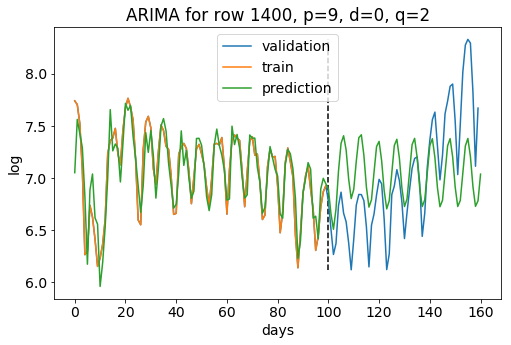

In [11]:
ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
           preds_0, 'ARIMA for row %i, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

In [12]:
# d = 1
preds_1, idx, pdq = ARIMA_for_row(i, forecast=False, d=1, return_params=True)
print(pdq)

called
[9, 1, 2]


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


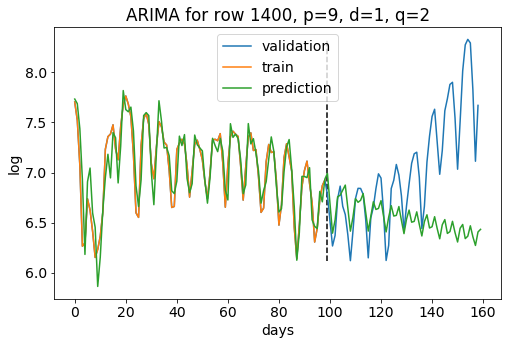

In [13]:
ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
           preds_1, 'ARIMA for row %i, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

# Weekly seasonal

called


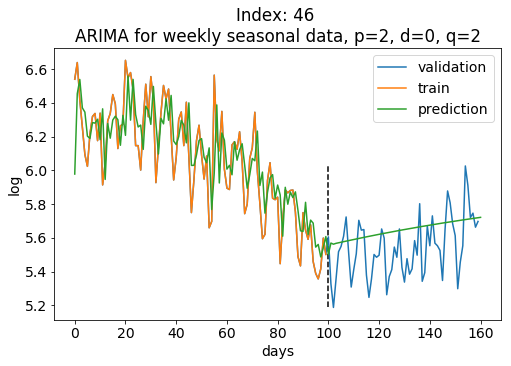

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


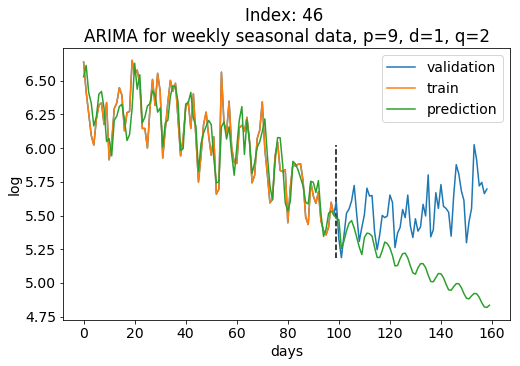

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


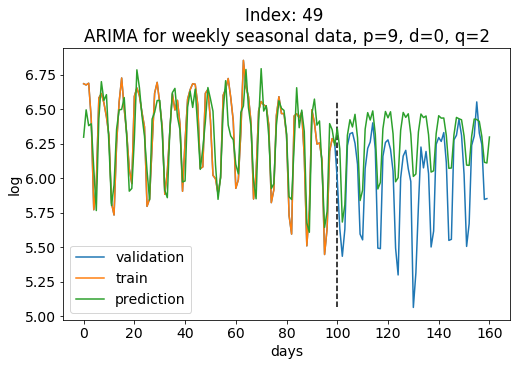

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


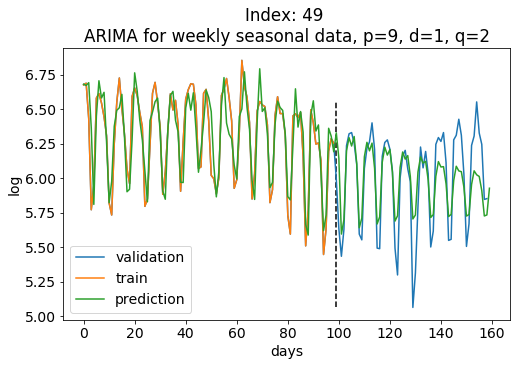

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


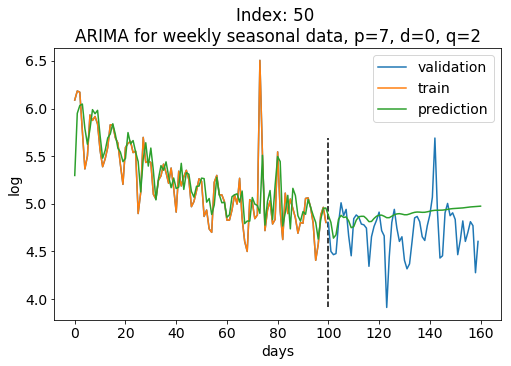

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


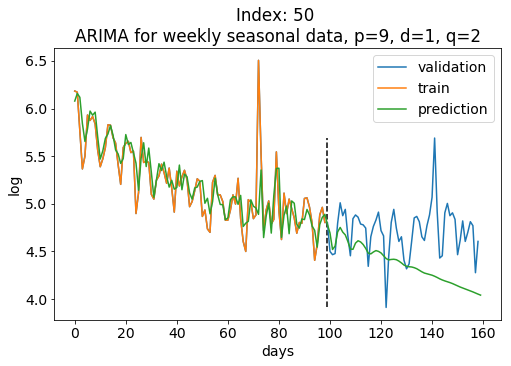

called
ARIMA failed


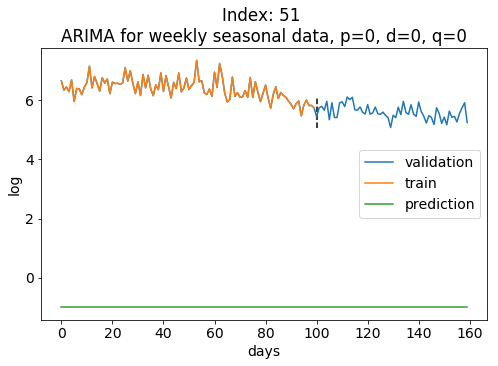

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


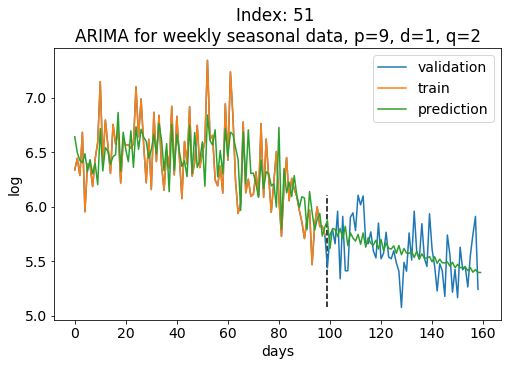

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


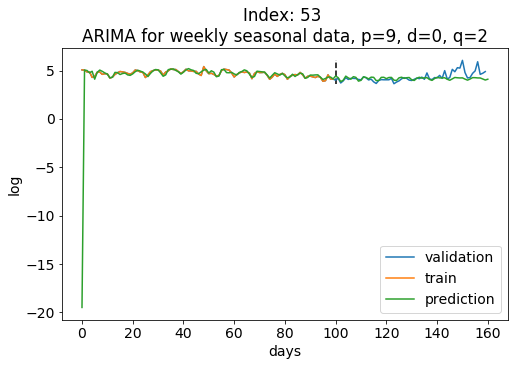

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


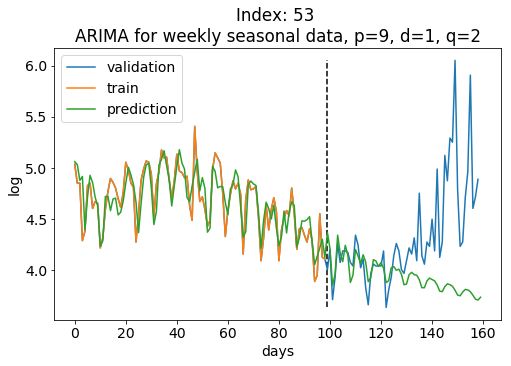

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


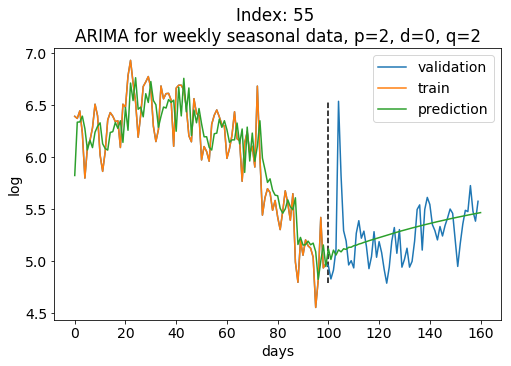

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


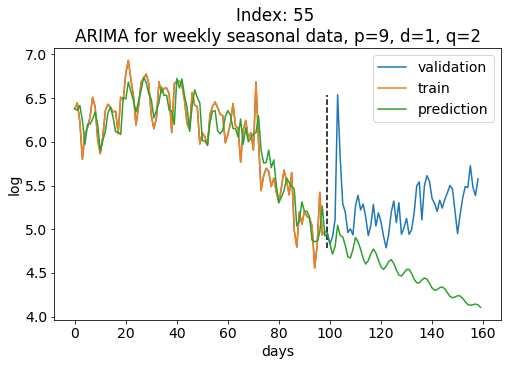

In [14]:
for i in weekly_indices[:6].ravel():
    row_train = log_train_for_val[i]

    # d = 0. stationary
    preds_0, idx, pdq = ARIMA_for_row(i, forecast=False, d=0, return_params=True)
    if preds_1[0] != -1:
        ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
                   preds_0, 'Index: %i \nARIMA for weekly seasonal data, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

    # d = 1
    preds_1, idx, pdq = ARIMA_for_row(i, forecast=False, d=1, return_params=True)
    if preds_1[0] != -1:
        ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
                   preds_1, 'Index: %i \nARIMA for weekly seasonal data, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

# Many zeros

called


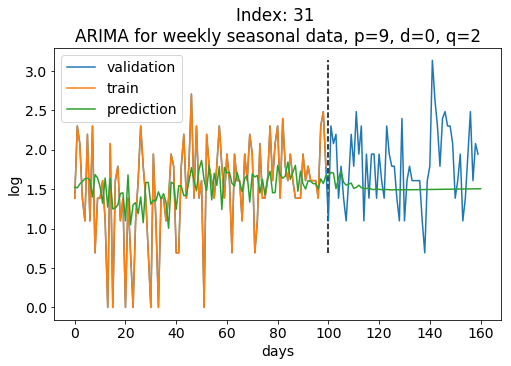

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


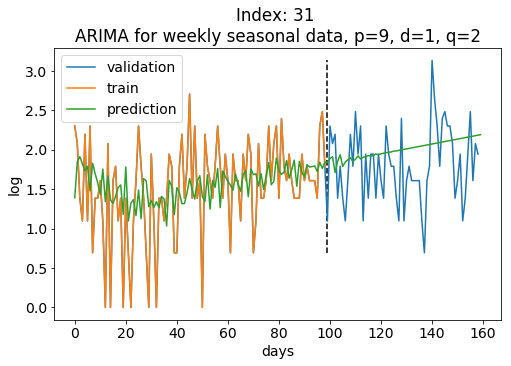

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


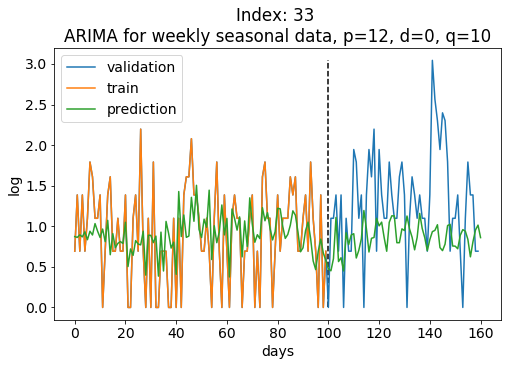

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


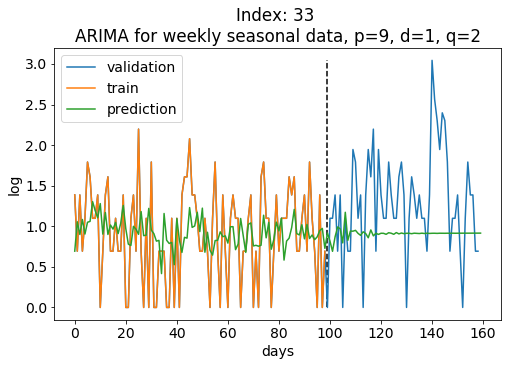

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


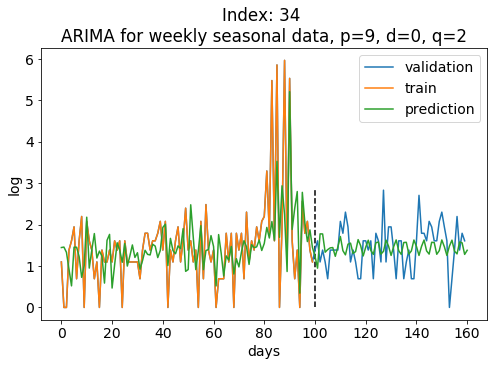

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


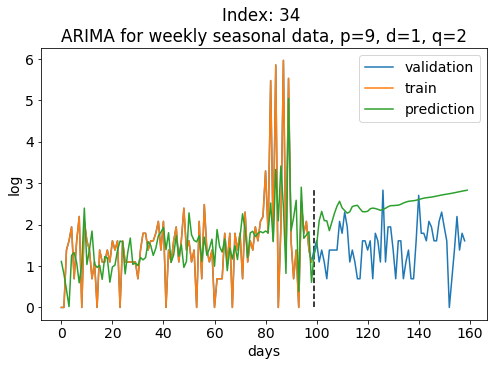

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/shirobokov/.local/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


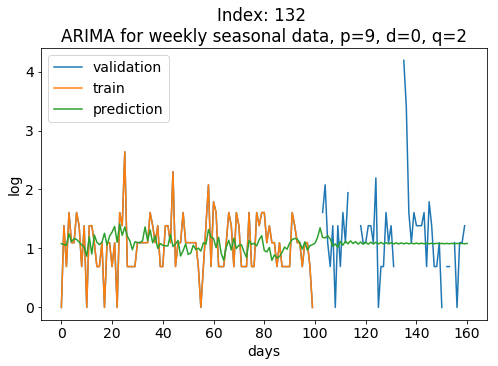

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


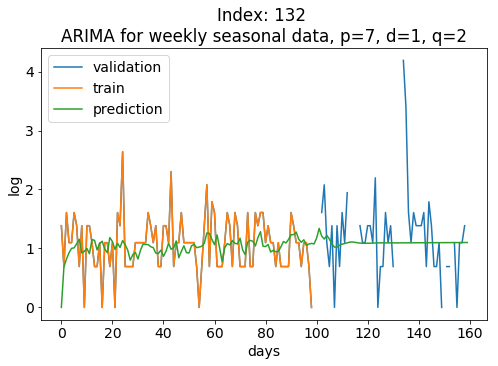

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


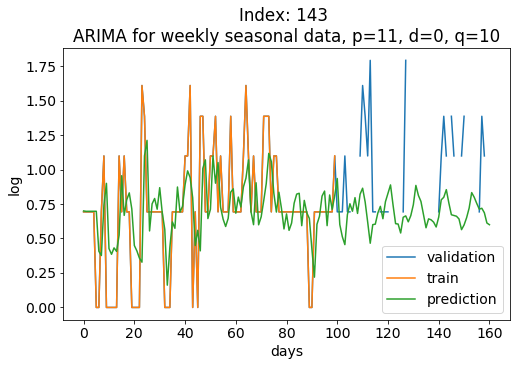

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


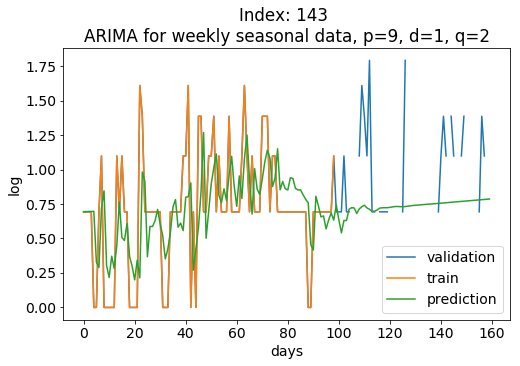

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


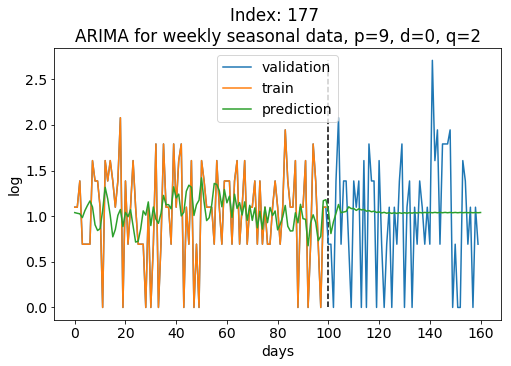

called


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


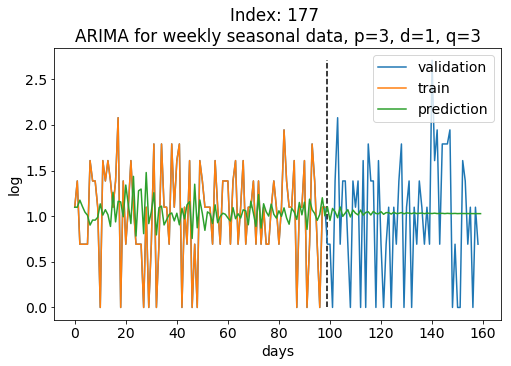

In [15]:
for i in zeros_indices[:6].ravel():
    row_train = log_train_for_val[i]

    # d = 0. stationary
    preds_0, idx, pdq = ARIMA_for_row(i, forecast=False, d=0, return_params=True)
    if preds_1[0] != -1:
        ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
                   preds_0, 'Index: %i \nARIMA for weekly seasonal data, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

    # d = 1
    preds_1, idx, pdq = ARIMA_for_row(i, forecast=False, d=1, return_params=True)
    if preds_1[0] != -1:
        ARIMA_plot(row_train, idx, np.log1p(np.array(test.iloc[i])), 
                   preds_1, 'Index: %i \nARIMA for weekly seasonal data, p=%i, d=%i, q=%i' % (i, pdq[0], pdq[1], pdq[2]))

# Parallel

In [11]:
from joblib import Parallel, delayed

In [14]:
%%time
predictions_0 = Parallel(n_jobs=7, max_nbytes=None)(
    delayed(ARIMA_for_row)(k, d=0) 
    for k in range(7)
)
print('end')
predictions_0 = np.array(predictions_0)

called
called
called
called
called
called
called
5 prediction ready
1 prediction ready


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 prediction ready


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


6 prediction ready


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 prediction ready


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 prediction ready


/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/shirobokov/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 prediction ready
end
CPU times: user 288 ms, sys: 124 ms, total: 412 ms
Wall time: 5min 43s


In [15]:
predictions_0 = utils.from_log_and_correction(predictions_0) 

In [ ]:
utils.SaveModel("arima_d_0",
                predictions_0, test,
                "24 hours", "no transformation",
                index.values.reshape(-1))

In [ ]:
%%time
predictions_1 = Parallel(n_jobs=24, max_nbytes=None)(
    delayed(ARIMA_for_row)(k, d=1) 
    for k in range(2000)
)
print('end')
predictions_1 = np.array(predictions_1)

In [15]:
predictions_1 = utils.from_log_and_correction(predictions_1) 

In [ ]:
utils.SaveModel("arima_d_1",
                predictions_1, test,
                "24 hours", "no transformation",
                index.values.reshape(-1))

In [26]:
# d = 0
np.nanmean(utils.SMAPE_score(predictions_0, test[:10]))

RMSLE:  0.5663540859741393


0.5663540859741393

In [184]:
# with trend
# np.nanmean(utils.RMSLE_score(y_pred, test[:10]))

RMSLE:  0.9096580694263237


0.9096580694263237